In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import csv
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras import backend as K
from keras.models import model_from_json,load_model

from keras.metrics import Precision
from keras.metrics import Recall

from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
import glob

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
normal_image_path=os.path.join(os.getcwd(),'drive','MyDrive','archive','normal')
pot_image_path=os.path.join(os.getcwd(),'drive','MyDrive','archive','potholes')

In [4]:
IMG_HEIGHT=256
IMG_WIDTH=256
IMG_CHANNELS=3

In [5]:
X_train=list()
X_test=list()
y_train=list()
y_test=list()

In [27]:
train_data=list()
target_data=list()

for file_name in os.listdir(normal_image_path):
  train_data.append(os.path.join(normal_image_path,file_name))
  target_data.append(0)

for file_name in os.listdir(pot_image_path):
  train_data.append(os.path.join(pot_image_path,file_name))
  target_data.append(1)

print(len(train_data),len(target_data))

for i in range(0,5):
  print(train_data[i],target_data[i])

for i in range(len(train_data)-5,len(train_data)):
  print(train_data[i],target_data[i])

681 681
/content/drive/MyDrive/archive/normal/109.jpg 0
/content/drive/MyDrive/archive/normal/113.jpg 0
/content/drive/MyDrive/archive/normal/102.jpg 0
/content/drive/MyDrive/archive/normal/108.jpg 0
/content/drive/MyDrive/archive/normal/104.jpg 0
/content/drive/MyDrive/archive/potholes/88.jpg 1
/content/drive/MyDrive/archive/potholes/80.jpg 1
/content/drive/MyDrive/archive/potholes/82.jpg 1
/content/drive/MyDrive/archive/potholes/85.jpg 1
/content/drive/MyDrive/archive/potholes/84.jpg 1


In [28]:
from tqdm import tqdm_notebook, tnrange

X=list()
y=list()

for n,val in tqdm_notebook(enumerate(train_data), total=len(train_data)):
  try:
    img = cv2.imread(train_data[n])
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    X.append(img)
    y.append(target_data[n])
  except:
    continue
  
X=np.array(X)
y=np.array(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, random_state=42, test_size = 0.2 )

print(X_train.shape)
print(y_train.shape)


(544, 256, 256, 3)
(544,)


Data Normalization

In [30]:
from keras.utils import normalize, to_categorical

X_train = normalize(X_train, axis=1)
X_valid = normalize(X_valid, axis=1)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)


In [31]:
activation = 'sigmoid'
model = Sequential()
model.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)))
model.add(BatchNormalization())

model.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(64, activation = activation, kernel_initializer = 'he_uniform'))
model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary()) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 64)     

In [33]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-pothole-1.h5', verbose=1, save_best_only=True)
history = model.fit(X_train,y_train,epochs = 500, validation_data = (X_valid, y_valid))
model.save(os.path.join(os.getcwd(),'model-pothole-1.h5'))

Epoch 1/500
17/17 [==============================] - 2s 100ms/step - loss: 0.1801 - accuracy: 0.9301 - val_loss: 3.4855 - val_accuracy: 0.3676
Epoch 2/500
17/17 [==============================] - 2s 100ms/step - loss: 0.1625 - accuracy: 0.9467 - val_loss: 3.4358 - val_accuracy: 0.3676
Epoch 3/500
17/17 [==============================] - 2s 100ms/step - loss: 0.1413 - accuracy: 0.9485 - val_loss: 3.7506 - val_accuracy: 0.3676
Epoch 4/500
17/17 [==============================] - 2s 100ms/step - loss: 0.1666 - accuracy: 0.9393 - val_loss: 3.7127 - val_accuracy: 0.3676
Epoch 5/500
17/17 [==============================] - 2s 100ms/step - loss: 0.1429 - accuracy: 0.9540 - val_loss: 1.1300 - val_accuracy: 0.5221
Epoch 6/500
17/17 [==============================] - 2s 100ms/step - loss: 0.1585 - accuracy: 0.9522 - val_loss: 1.9788 - val_accuracy: 0.3824
Epoch 7/500
17/17 [==============================] - 2s 100ms/step - loss: 0.1622 - accuracy: 0.9449 - val_loss: 0.5909 - val_accuracy: 0.6912

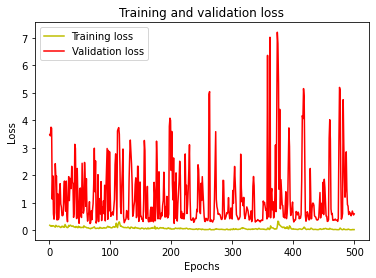

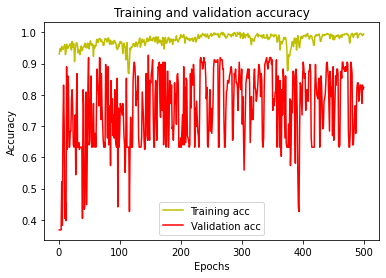

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
loaded_model=load_model('model-pothole-1.h5')

In [36]:
y_train_pred=loaded_model.predict(X_train)
y_train_pred=np.argmax(y_train_pred,axis=-1)
y_train_backup=np.argmax(y_train,axis=-1)

y_valid_pred=loaded_model.predict(X_valid)
y_valid_pred=np.argmax(y_valid_pred,axis=-1)
y_valid_backup=np.argmax(y_valid,axis=-1)


In [ ]:
print(y_valid_)

In [38]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

print('Accuracy:', accuracy_score(y_train_backup, y_train_pred))
print('Precision:', precision_score(y_train_backup, y_train_pred,average='weighted'))
print('Recall:', recall_score(y_train_backup, y_train_pred,average='weighted'))
print('F1 score:', f1_score(y_train_backup, y_train_pred,average='weighted'))


Accuracy: 0.9301470588235294
Precision: 0.9385205975134534
Recall: 0.9301470588235294
F1 score: 0.9296763413992214


In [39]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

print('Accuracy:', accuracy_score(y_valid_backup, y_valid_pred))
print('Precision:', precision_score(y_valid_backup, y_valid_pred,average='weighted'))
print('Recall:', recall_score(y_valid_backup, y_valid_pred,average='weighted'))
print('F1 score:', f1_score(y_valid_backup, y_valid_pred,average='weighted'))


Accuracy: 0.8235294117647058
Precision: 0.8652915711739242
Recall: 0.8235294117647058
F1 score: 0.8266253869969041
